In [69]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np

import plotly.express as px

In [2]:
path = "/Users/coes3/phd-labs/fraganal/data_source/shut/"
filepath = "/Users/coes3/phd-labs/fraganal/data_source/cc_alpha2.csv"

In [21]:
files = Path(path).glob('*.csv')
dfs = []

for i in files:
    data = pd.read_csv(i, header=0)
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

cc_df = pd.read_csv(filepath)
df = df.join(cc_df.set_index('Name'), on='country')
df.rename(columns = {'Code':'cc'}, inplace = True)

cc_list = ['CN','BR','DE','IN','IQ', 'RW']
df = df[df['cc'].isin(cc_list)]

columns = ['start_date', 'end_date', 'cc', 'geo_scope', 'shutdown_type', 
           'affected_network', 'shutdown_extent']
df = df[columns]

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df = df.loc[(df['start_date'] >= '2022-01-01') & (df['start_date'] <='2022-12-31')]


In [22]:
df['geo_scope'].replace('It affected locations in more than one state, province, or region','Country', inplace=True)
df['geo_scope'].replace('It affected more than one city in the same state, province, or region','Ctate', inplace=True)
df['geo_scope'].replace('It only affected one city, county, or village','City', inplace=True)
df['geo_scope'].replace('Not sure','Unknown', inplace=True)

In [23]:
df.dropna(subset=['start_date', 'end_date'], inplace=True)

In [24]:
df['duration'] = df['end_date'] - df['start_date']
df['duration'] = df['duration'].astype('timedelta64[D]')

In [25]:
df

,start_date,end_date,cc,geo_scope,shutdown_type,affected_network,shutdown_extent,duration
17,2022-01-03,2022-01-05,IN,City,Shutdown,Mobile,Full network,2.0
19,2022-01-05,2022-01-05,IN,City,Shutdown,Mobile,Full network,0.0
20,2022-01-06,2022-01-08,IN,City,Shutdown,Mobile,Full network,2.0
22,2022-01-09,2022-01-10,IN,City,Shutdown,Mobile,Full network,1.0
23,2022-01-09,2022-01-11,IN,City,Shutdown,Mobile,Full network,2.0
...,...,...,...,...,...,...,...,...
171,2022-11-13,2022-11-14,IN,City,Shutdown,Unknown,Full network,1.0
175,2022-11-22,2022-11-28,IN,Ctate,Shutdown,Mobile,Full network,6.0
177,2022-11-24,2022-11-26,IN,City,Shutdown,Unknown,Full network,2.0
179,2022-12-03,2022-12-05,IN,City,Shutdown,Mobile,Full network,2.0


In [132]:
df2 = df.groupby(['start_date','cc', 'shutdown_extent'])['duration'].agg(['sum','count'])
df2.reset_index(inplace=True)
df2.rename(columns={"count":"event_count", "sum":"duration"}, inplace = True)

In [140]:
df2 = df.groupby(['start_date','cc', 'shutdown_extent','duration'])['duration'].agg(['count'])
df2.reset_index(inplace=True)
df2.rename(columns={"count":"event_count", "sum":"duration"}, inplace = True)

In [141]:
df2

,start_date,cc,shutdown_extent,duration,event_count
0,2022-01-03,IN,Full network,2.0,1
1,2022-01-05,IN,Full network,0.0,1
2,2022-01-06,IN,Full network,2.0,1
3,2022-01-09,IN,Full network,1.0,1
4,2022-01-09,IN,Full network,2.0,1
...,...,...,...,...,...
73,2022-11-13,IN,Full network,1.0,1
74,2022-11-22,IN,Full network,6.0,1
75,2022-11-24,IN,Full network,2.0,1
76,2022-12-03,IN,Full network,2.0,1


In [142]:
def plot_graph(df):
    g = sns.FacetGrid(df, col='cc', hue='shutdown_extent', col_wrap=3, height=4, aspect=2)
    g.map_dataframe(sns.scatterplot, 'start_date', 'event_count', size='duration').add_legend()
    g.set_xticklabels(rotation=45, ha='right')

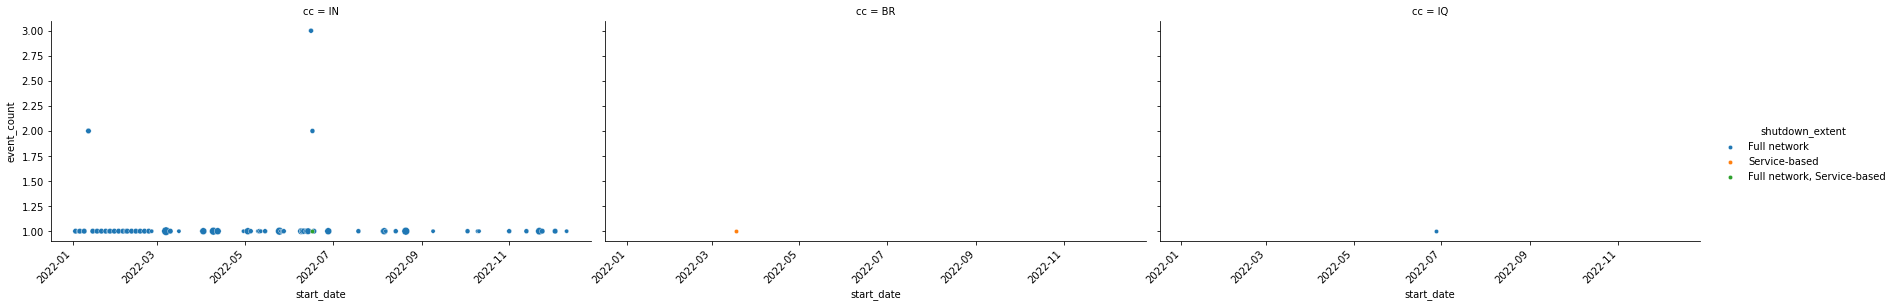

In [143]:
plot_graph(df2)

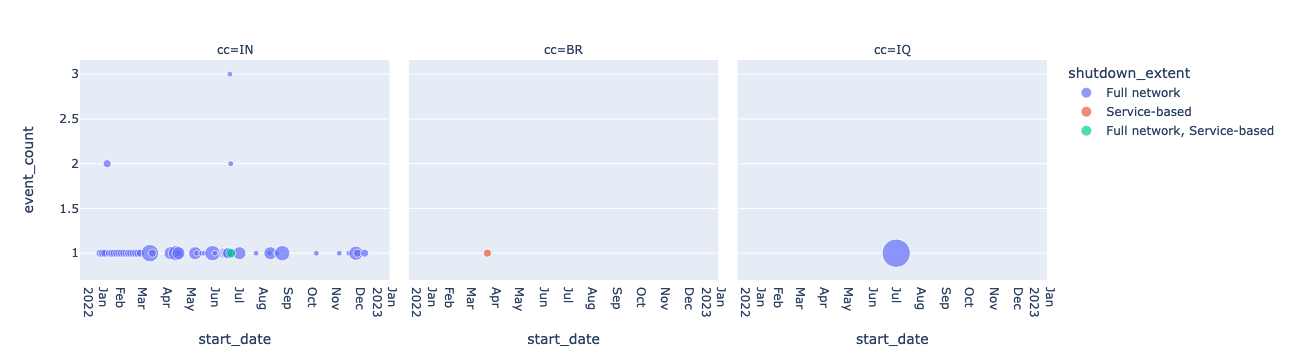

In [158]:
fig = px.scatter(df2, x="start_date", y="event_count", color="shutdown_extent", size='duration', facet_col="cc",facet_col_wrap=3, hover_data=['duration'])
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    showgrid=False)
fig.show()